# Steam Games Recommendation System

In this project I intent to make make a recommender system using a content-based filtering, by utilizing the Cosine Similarity method to find Steam games recommendations.

## Imports

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity

## Data Loading and Inspection

The dataset is https://www.kaggle.com/datasets/fronkongames/steam-games-dataset/data. The dataset is given in a CSV and a JSON format.

The CSV file seems to be corrupt since it fails to load with pandas.read_csv(), however I can still proceed, i just need to convert the json file to a csv file.

In [26]:
json_path = "games.json"
df = pd.read_json(json_path)
df = df.T
df.reset_index(inplace=True)
df.rename(columns={"index": "AppID"}, inplace=True)
list_columns = ["supported_languages", "full_audio_languages", "developers", "publishers", "categories", "genres", "screenshots", "movies"]
for col in list_columns:
    df[col] = df[col].apply(lambda x: ",".join(x) if isinstance(x, list) else x)
df["tags"] = df["tags"].apply(lambda x: ",".join(x.keys()) if isinstance(x, dict) else "")
df.head()

,AppID,name,release_date,required_age,price,dlc_count,detailed_description,about_the_game,short_description,reviews,...,score_rank,positive,negative,estimated_owners,average_playtime_forever,average_playtime_2weeks,median_playtime_forever,median_playtime_2weeks,peak_ccu,tags
0,20200,Galactic Bowling,"Oct 21, 2008",0,19.99,0,Galactic Bowling is an exaggerated and stylize...,Galactic Bowling is an exaggerated and stylize...,Galactic Bowling is an exaggerated and stylize...,,...,,6,11,0 - 20000,0,0,0,0,0,"Indie,Casual,Sports,Bowling"
1,655370,Train Bandit,"Oct 12, 2017",0,0.99,0,THE LAW!! Looks to be a showdown atop a train....,THE LAW!! Looks to be a showdown atop a train....,THE LAW!! Looks to be a showdown atop a train....,,...,,53,5,0 - 20000,0,0,0,0,0,"Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc..."
2,1732930,Jolt Project,"Nov 17, 2021",0,4.99,0,Jolt Project: The army now has a new robotics ...,Jolt Project: The army now has a new robotics ...,"Shoot vehicles, blow enemies with a special at...",,...,,0,0,0 - 20000,0,0,0,0,0,
3,1355720,Henosis™,"Jul 23, 2020",0,5.99,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,HENOSIS™ is a mysterious 2D Platform Puzzler w...,HENOSIS™ is a mysterious 2D Platform Puzzler w...,,...,,3,0,0 - 20000,0,0,0,0,0,"2D Platformer,Atmospheric,Surreal,Mystery,Puzz..."
4,1139950,Two Weeks in Painland,"Feb 3, 2020",0,0.0,0,ABOUT THE GAME Play as a hacker who has arrang...,ABOUT THE GAME Play as a hacker who has arrang...,Two Weeks in Painland is a story-driven game a...,,...,,50,8,0 - 20000,0,0,0,0,0,"Indie,Adventure,Nudity,Violent,Sexual Content,..."


Now that's done, however i would still like to use the column titles from the original csv file. Let's make a dictionary of column mappings and apply said mapping.

In [27]:
column_mapping = {
    "AppID": "AppID",
    "name": "Name",
    "release_date": "Release date",
    "estimated_owners": "Estimated owners",
    "peak_ccu": "Peak CCU",
    "required_age": "Required age",
    "price": "Price",
    "dlc_count": "DiscountDLC count",
    "about_the_game": "About the game",
    "supported_languages": "Supported languages",
    "full_audio_languages": "Full audio languages",
    "reviews": "Reviews",
    "header_image": "Header image",
    "website": "Website",
    "support_url": "Support url",
    "support_email": "Support email",
    "windows": "Windows",
    "mac": "Mac",
    "linux": "Linux",
    "metacritic_score": "Metacritic score",
    "metacritic_url": "Metacritic url",
    "user_score": "User score",
    "positive": "Positive",
    "negative": "Negative",
    "score_rank": "Score rank",
    "achievements": "Achievements",
    "recommendations": "Recommendations",
    "notes": "Notes",
    "average_playtime_forever": "Average playtime forever",
    "average_playtime_2weeks": "Average playtime two weeks",
    "median_playtime_forever": "Median playtime forever",
    "median_playtime_2weeks": "Median playtime two weeks",
    "developers": "Developers",
    "publishers": "Publishers",
    "categories": "Categories",
    "genres": "Genres",
    "tags": "Tags",
    "screenshots": "Screenshots",
    "movies": "Movies",
}

df.rename(columns=column_mapping, inplace=True)
column_order = list(column_mapping.values())
df = df[column_order]

Time to save it, so i dont have to process the json at every run.

In [28]:
df.to_csv("gamesv2.csv", index=False)
df.head()

,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DiscountDLC count,About the game,Supported languages,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,Galactic Bowling is an exaggerated and stylize...,English,...,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,THE LAW!! Looks to be a showdown atop a train....,"English,French,Italian,German,Spanish - Spain,...",...,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,Jolt Project: The army now has a new robotics ...,"English,Portuguese - Brazil",...,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
3,1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"English,French,Italian,German,Spanish - Spain,...",...,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
4,1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.0,0,ABOUT THE GAME Play as a hacker who has arrang...,"English,Spanish - Spain",...,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


I'm doing a fresh load of the newly created csv, just to make sure everything looks alright, and it seems to so let's proceed.

In [29]:
df = pd.read_csv("gamesv2.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97410 entries, 0 to 97409
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AppID                       97410 non-null  int64  
 1   Name                        97404 non-null  object 
 2   Release date                97410 non-null  object 
 3   Estimated owners            97410 non-null  object 
 4   Peak CCU                    97410 non-null  int64  
 5   Required age                97410 non-null  int64  
 6   Price                       97410 non-null  float64
 7   DiscountDLC count           97410 non-null  int64  
 8   About the game              92540 non-null  object 
 9   Supported languages         92579 non-null  object 
 10  Full audio languages        40393 non-null  object 
 11  Reviews                     10125 non-null  object 
 12  Header image                97410 non-null  object 
 13  Website                     427

,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DiscountDLC count,About the game,Supported languages,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,Galactic Bowling is an exaggerated and stylize...,English,...,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,THE LAW!! Looks to be a showdown atop a train....,"English,French,Italian,German,Spanish - Spain,...",...,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,Jolt Project: The army now has a new robotics ...,"English,Portuguese - Brazil",...,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
3,1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"English,French,Italian,German,Spanish - Spain,...",...,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
4,1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,ABOUT THE GAME Play as a hacker who has arrang...,"English,Spanish - Spain",...,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


## Exploratory Data Analysis (EDA)

### Checking for Missing Values

Before I start with visualizations, let's clean up any missing values.


In [30]:
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

Name                        6
About the game           4870
Supported languages      4831
Full audio languages    57017
Reviews                 87285
Website                 54673
Support url             51510
Support email           16035
Metacritic url          93457
Score rank              97366
Notes                   81937
Developers               4877
Publishers               5171
Categories               5913
Genres                   4841
Tags                    29763
Screenshots              2895
Movies                   7891
dtype: int64

### Handling Missing Values

Some columns contain missing values that might impact our recommender system. We'll take the following steps:

- Name: This is an important identifier, so I'll drop rows where it's missing.
- Genres, Categories, Tags, Supported languages: These columns will be crucial for understanding each games characteristics, so I will replace any missing value with Unknown.


In [31]:
df = df.dropna(subset=['Name'])

fill_cols = ["Genres", "Categories", "Tags", "Supported languages"]
df[fill_cols] = df[fill_cols].fillna("Unknown")

df.isnull().sum()

AppID                             0
Name                              0
Release date                      0
Estimated owners                  0
Peak CCU                          0
Required age                      0
Price                             0
DiscountDLC count                 0
About the game                 4865
Supported languages               0
Full audio languages          57012
Reviews                       87279
Header image                      0
Website                       54667
Support url                   51504
Support email                 16029
Windows                           0
Mac                               0
Linux                             0
Metacritic score                  0
Metacritic url                93451
User score                        0
Positive                          0
Negative                          0
Score rank                    97360
Achievements                      0
Recommendations                   0
Notes                       

### Dropping Remaining Null Columns

There's still some columns that have way too many missing values and wont be useful for the recommender system.

I'll drop these columns to clean the dataset.


In [32]:
drop_cols = ["Metacritic url", "Notes", "Website", "Support url", "Support email", "Movies", "Screenshots", "Score rank", "Release date", "Estimated owners", "About the game", "Reviews", "Header image", "Full audio languages", "Developers", "Publishers"]
df = df.drop(columns=drop_cols)
df.isnull().sum()

AppID                         0
Name                          0
Peak CCU                      0
Required age                  0
Price                         0
DiscountDLC count             0
Supported languages           0
Windows                       0
Mac                           0
Linux                         0
Metacritic score              0
User score                    0
Positive                      0
Negative                      0
Achievements                  0
Recommendations               0
Average playtime forever      0
Average playtime two weeks    0
Median playtime forever       0
Median playtime two weeks     0
Categories                    0
Genres                        0
Tags                          0
dtype: int64

### Correlation Matrix

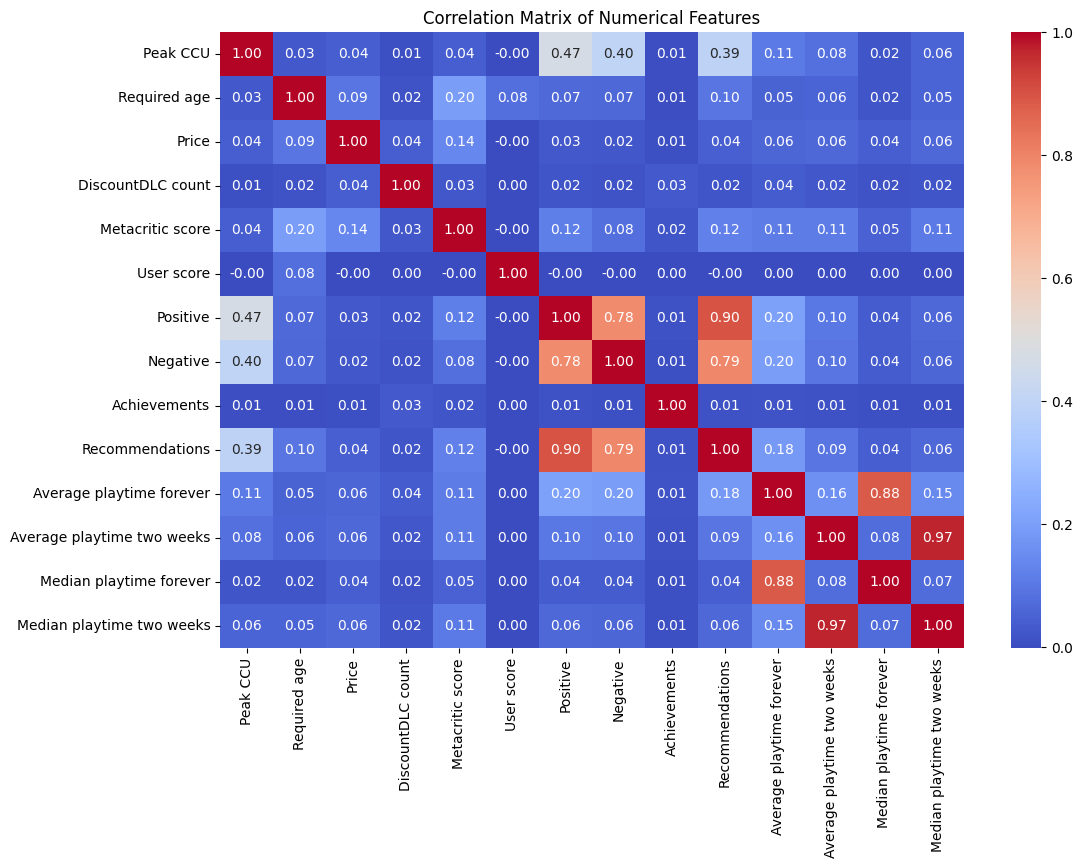

In [33]:
num_cols = ["Peak CCU", "Required age", "Price", "DiscountDLC count", "Metacritic score", "User score", "Positive", "Negative", "Achievements", "Recommendations", "Average playtime forever", "Average playtime two weeks", "Median playtime forever", "Median playtime two weeks"]
df_num = df[num_cols]
correlation_matrix = df_num.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

From the correlation matrix I can see there's very strong correlation between games recommendations and positive as well as negative steam reviews.

To see negative reviews having a high correlation to recommendations could be counterintuitive at first glance. However it could mean that games with a high number of positive reviews also have a high number of negative reviews, which could mean that it's a popular game.

There's also a high correlation between the average and mean playtimes which just tells me that there's not many outliers in the dataset.

### Data Visualization

Time to visualize the data.

#### Top 10 Genres


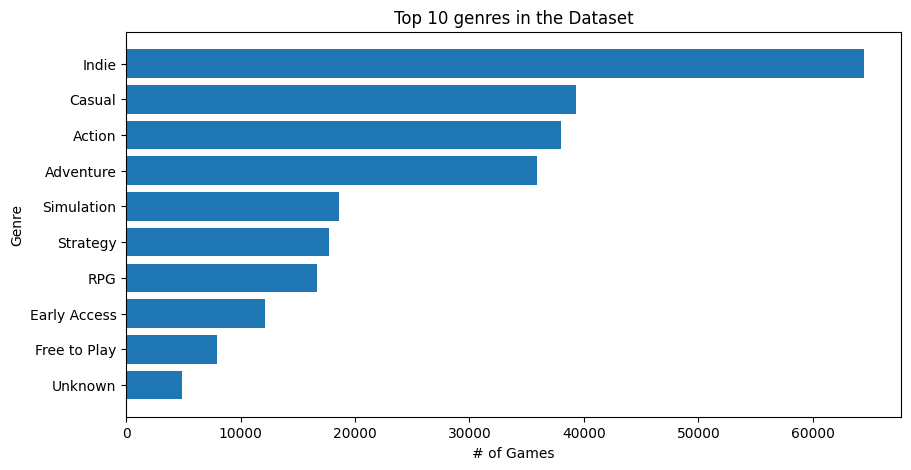

In [34]:
genre_counts = Counter([genre for sublist in df['Genres'].dropna().str.split(',') for genre in sublist])
top_genres = genre_counts.most_common(10)

plt.figure(figsize=(10,5))
plt.barh([x[0] for x in reversed(top_genres)], [x[1] for x in reversed(top_genres)])
plt.xlabel("# of Games")
plt.ylabel("Genre")
plt.title("Top 10 genres in the Dataset")
plt.show()


A lot of indie games, which do make sense since the boom after the Steam Wishlist feature.

#### Top 10 Categories

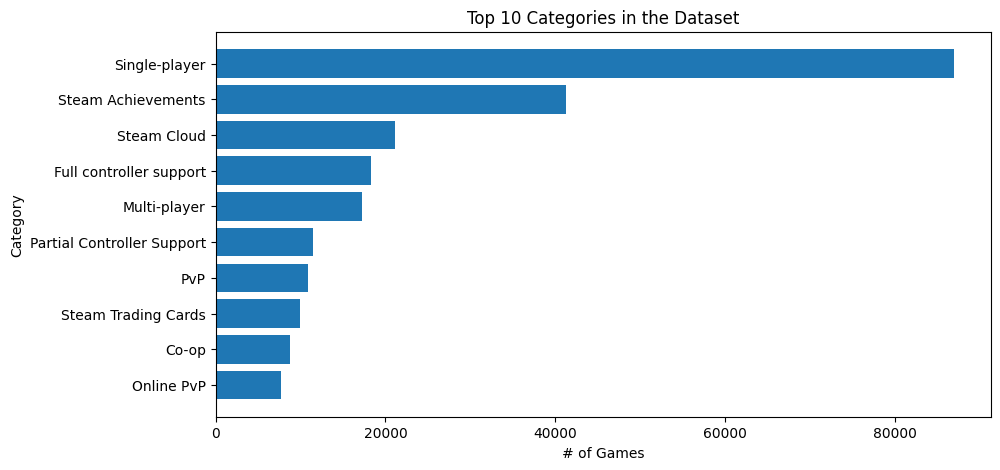

In [35]:
category_counts = Counter([cat for sublist in df['Categories'].dropna().str.split(',') for cat in sublist])
top_categories = category_counts.most_common(10)

plt.figure(figsize=(10,5))
plt.barh([x[0] for x in reversed(top_categories)], [x[1] for x in reversed(top_categories)])
plt.xlabel("# of Games")
plt.ylabel("Category")
plt.title("Top 10 Categories in the Dataset")
plt.show()


Steam being dominant of single-player games makes perfect sense.

#### Top 10 Tags

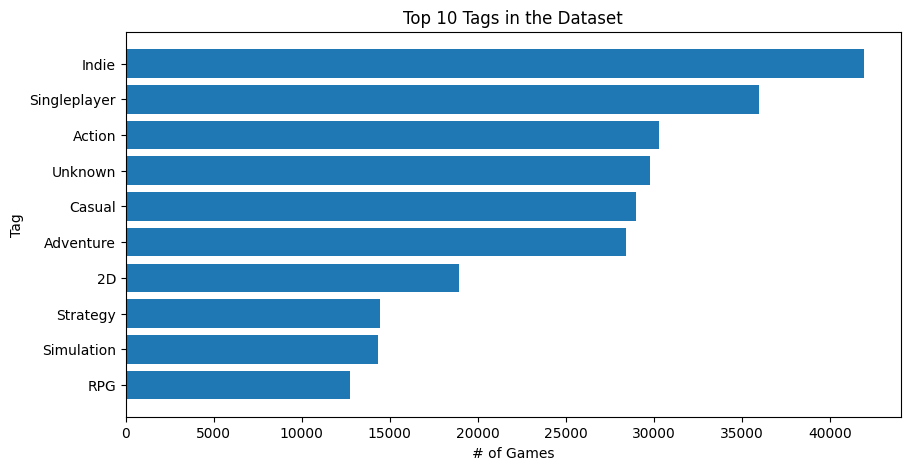

In [36]:
tag_counts = Counter([tag for sublist in df['Tags'].dropna().str.split(',') for tag in sublist])
top_tags = tag_counts.most_common(10)

plt.figure(figsize=(10,5))
plt.barh([x[0] for x in reversed(top_tags)], [x[1] for x in reversed(top_tags)])
plt.xlabel("# of Games")
plt.ylabel("Tag")
plt.title("Top 10 Tags in the Dataset")
plt.show()


A shocking amount of Tags with Unknown, this might affect my recommender system outcomes negatively.

#### Price Distribution

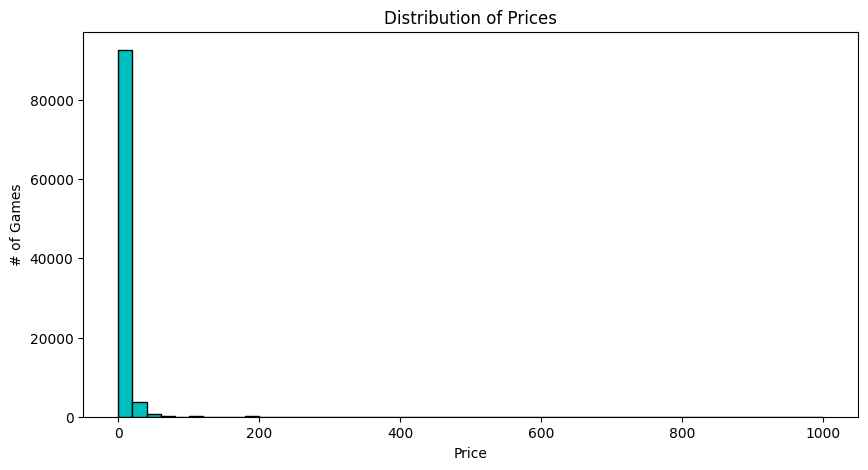

In [37]:
plt.figure(figsize=(10,5))
plt.hist(df["Price"], bins=50, color='c', edgecolor='black')
plt.xlabel("Price")
plt.ylabel("# of Games")
plt.title("Distribution of Prices")
plt.show()

There's a lot of free to play games in this dataset, it might be my age but I assumed there had to be more paid games on steam than what is displayed in the data.

#### Distribution of Peak CCU

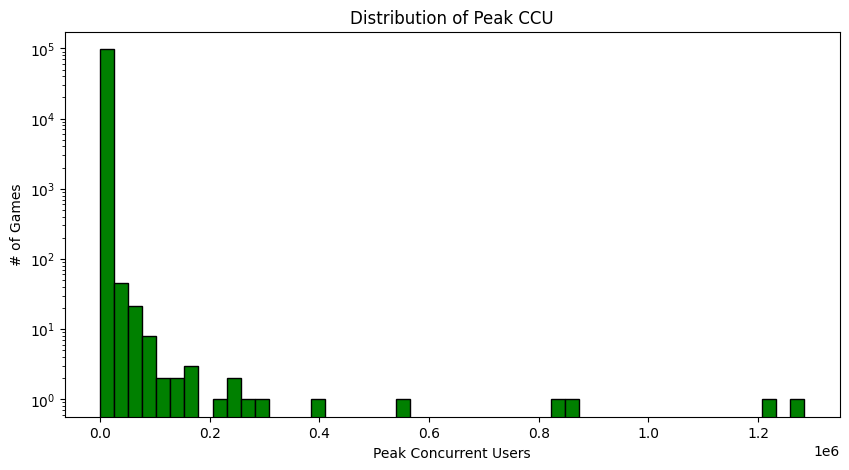

In [38]:
plt.figure(figsize=(10,5))
plt.hist(df["Peak CCU"], bins=50, color='g', edgecolor='black', log=True)
plt.xlabel("Peak Concurrent Users")
plt.ylabel("# of Games")
plt.title("Distribution of Peak CCU")
plt.show()

It's interesting to see how most games are "dead", however it doesn't surprise me on a platform like Steam, that it would be full of barely played games.

#### Distribution of Average Playtime Forever

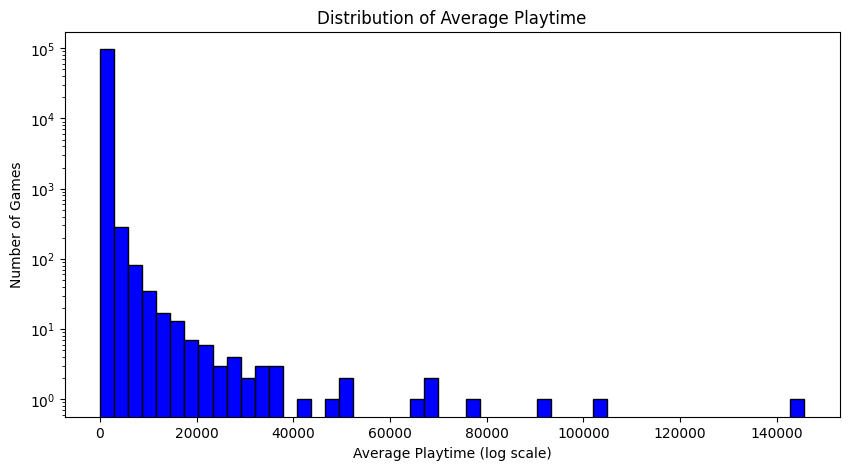

In [39]:
plt.figure(figsize=(10,5))
plt.hist(df["Average playtime forever"], bins=50, color='b', edgecolor='black', log=True)
plt.xlabel("Average Playtime (log scale)")
plt.ylabel("Number of Games")
plt.title("Distribution of Average Playtime")
plt.show()


This is a similar case, where there's a few ourliers with hours played in the range of 40k - 140k hours.

## Feature Selection

For cosine similarity I've selected the features that best represent game similarities. All numerical features will be scaled.

The categories Genres, Categories & Tags will be one-hot encoded as they are crucial for this recommender system.

In [40]:
numerical_features = ["Price", "Peak CCU", "Recommendations", "Average playtime forever", "Required age"]
scaler = MinMaxScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])
df[numerical_features].describe()

,Price,Peak CCU,Recommendations,Average playtime forever,Required age
count,97404.000000,9.740400e+04,97404.000000,97404.000000,97404.000000
mean,0.007087,1.267168e-04,0.000201,0.000630,0.013453
std,0.012388,5.985786e-03,0.004887,0.007332,0.102112
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000990,0.000000e+00,0.000000,0.000000,0.000000
50%,0.004190,0.000000e+00,0.000000,0.000000,0.000000
75%,0.009990,7.786537e-07,0.000000,0.000000,0.000000
max,1.000000,1.000000e+00,1.000000,1.000000,1.000000


In [41]:
df["Genres"] = df["Genres"].str.split(",")
df["Tags"] = df["Tags"].str.split(",")
df["Categories"] = df["Categories"].str.split(",")
df["Supported languages"] = df["Supported languages"].str.split(",")

mlb_genres = MultiLabelBinarizer()
mlb_tags = MultiLabelBinarizer()
mlb_categories = MultiLabelBinarizer()
mlb_languages = MultiLabelBinarizer()

genres_encoded = pd.DataFrame(mlb_genres.fit_transform(df["Genres"]), columns=mlb_genres.classes_, index=df.index)
categories_encoded = pd.DataFrame(mlb_categories.fit_transform(df["Categories"]), columns=mlb_categories.classes_, index=df.index)
tags_encoded = pd.DataFrame(mlb_tags.fit_transform(df["Tags"]), columns=mlb_tags.classes_, index=df.index)
language_encoded = pd.DataFrame(mlb_languages.fit_transform(df["Supported languages"]), columns=mlb_languages.classes_, index=df.index)

df = pd.concat([df, genres_encoded, tags_encoded, categories_encoded, language_encoded], axis=1)

df.drop(columns=["Genres", "Tags", "Categories", "Supported languages"], inplace=True)
df.shape

(97404, 685)

After encoding and scaling I'm left with 685 features. That's a managable amount, so I dont think I need to do any feature reduction like PCA for cosine similarity.

## Model Results

Time to test this recommender system out with a recommend function I have made.

In [42]:
def recommend_games(game_name, df, num_recommendations=5):
    if game_name not in df["Name"].values:
        return "Game missing in dataset"

    game_idx = df[df["Name"] == game_name].index[0]
    feature_cols = df.select_dtypes(include=['number']).columns
    df_features = df[feature_cols]

    similarities = cosine_similarity(df_features.loc[[game_idx]], df_features)[0]
    similar_indices = similarities.argsort()[::-1][1:num_recommendations*2]
    recommended_games = pd.unique(df.iloc[similar_indices]["Name"])[:num_recommendations].tolist()

    return recommended_games

In [43]:
game_to_recommend = "Counter-Strike"
recommendations = recommend_games(game_to_recommend, df)
print(f"Recommended games for '{game_to_recommend}': {recommendations}")

Recommended games for 'Counter-Strike': ['Half-Life 2', 'Left 4 Dead 2', 'Half-Life', 'Portal', "Garry's Mod"]


When asking for recommendation for the game title Counter-Strike, I get similar games from made on the Half-life engine, which I would assume is similar.

In [44]:
game_to_recommend = "DayZ"
recommendations = recommend_games(game_to_recommend, df)
print(f"Recommended games for '{game_to_recommend}': {recommendations}")

Recommended games for 'DayZ': ['RAGE', 'War Thunder', 'Fallout 3: Game of the Year Edition', 'Star Trek Online', 'Dead by Daylight']


For DayZ I get recommended popular games of different genres, but not too far off from the vibe that DayZ is.

In [45]:
game_to_recommend = "Moose Lost in the Woods"
recommendations = recommend_games(game_to_recommend, df)
print(f"Recommended games for '{game_to_recommend}': {recommendations}")

Recommended games for 'Moose Lost in the Woods': ['Lil Johnny Goes Home', 'Elong Plug', 'The Longest Walk', 'Undo The Jam Damage', 'Wolf West']


I got recommendations for a random kids game. After reviewing the recommendations on the Steam store, it's safe to say that it has indeed recommended me kid-friendly games of the same caliber as the input game title.

## Conclusion

I'm very pleased with the outcome of this recommender system. I am sure I could tweak this model even more to become even better and with some reduction even faster than 0.6s execution time. I did start off by attempting to do a K-means clustering on the dataset and the recommendation results were in east and west. It felt like a model which was fully random, then after considering the actual attributes in the dataset, i decided to go with consine similarity.